# Historical accuracy of sea ice extent in the CMIP6 experiment

## User question
How reliable are the historical estimates of the Arctic and Antarctic sea ice concentration and extent from the CMIP6 models?

## Methods
We compare sea ice concentrations from the [CMIP6](https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip6?tab=overview) historical experiment with that obtained from [passive microwave satellite products from EUMETSAT OSI- SAF and ESA CCI](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-sea-ice-concentration?tab=overview).  Time series of the evaluation metrics Integrated Ice Edge Error (IIEE), bias in extent and area, and the RMSE in sea ice concentration are produced and plotted. Decadal climatologies for both the models and observations are also produced and compared.

## Assessment statement
We find that the CMIP6 models generally underestimate the sea ice extent and area. While the Arctic sea ice minima are generally quite accurate, the Arctic maxima are consistently underestimated, as are the Antarctic extrema.

## Code

### Import libraries

In [1]:
import datetime
import warnings
import calendar
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
from cmocean import cm

from c3s_eqc_automatic_quality_control import diagnostics, download, plot

plt.style.use("seaborn-v0_8-notebook")
warnings.filterwarnings("ignore", module="cf_xarray")

### Set parameters

In [2]:
# Time
year_start = 1970
year_stop = 2019
assert year_start >= 1970 and year_stop <= 2019
assert not (year_start % 10 or (year_stop + 1) % 10)

# Sea Ice Concentration Threshold
sic_threshold = 30  # %

# Select masks
regions = ["northern_hemisphere", "southern_hemisphere"]
assert set(regions) <= {
    "northern_hemisphere",
    "southern_hemisphere",
}

# Choose CMIP6 historical models
models = [
    "access_cm2",
    "access_esm1_5",
    "cams_csm1_0",
    "canesm5",
    "canesm5_canoe",
    "cmcc_cm2_hr4",
    "cmcc_cm2_sr5",
    "cmcc_esm2",
    "cnrm_cm6_1",
    "cnrm_cm6_1_hr",
    "cnrm_esm2_1",
    "e3sm_1_0",
    "e3sm_1_1",
    "e3sm_1_1_eca",
    "ec_earth3_aerchem",
    "ec_earth3_cc",
    "ec_earth3_veg_lr",
    "fgoals_f3_l",
    "giss_e2_1_h",
    "hadgem3_gc31_ll",
    "hadgem3_gc31_mm",
    "inm_cm4_8",
    "inm_cm5_0",
    "ipsl_cm5a2_inca",
    "ipsl_cm6a_lr",
    "miroc6",
    "miroc_es2l",
    "mpi_esm1_2_hr",
    "mpi_esm1_2_lr",
    "mri_esm2_0",
    "nesm3",
    "norcpm1",
    "taiesm1",
    "ukesm1_0_ll",
]

### Define requests for CDS data

In [3]:
all_months = [f"{month:02d}" for month in range(1, 13)]

request_era5 = (
    "reanalysis-era5-single-levels-monthly-means",
    {
        "product_type": "monthly_averaged_reanalysis",
        "format": "netcdf",
        "time": "00:00",
        "variable": "sea_ice_cover",
        "year": [
            str(year)
            for year in range(
                max(year_start, 1940), min(year_stop + 1, datetime.date.today().year)
            )
        ],
        "month": all_months,
    },
)

request_cmip6_historical = (
    "projections-cmip6",
    {
        "format": "zip",
        "temporal_resolution": "monthly",
        "experiment": "historical",
        "variable": "sea_ice_area_percentage_on_ocean_grid",
        "year": [
            str(year) for year in range(max(year_start, 1850), min(year_stop, 2014) + 1)
        ],
        "month": all_months,
    },
)

request_eumetsat = (
    "satellite-sea-ice-concentration",
    download.update_request_date(
        {
            "cdr_type": "cdr",
            "origin": "eumetsat_osi_saf",
            "variable": "all",
            "version": "v2",
        },
        start=f"{max(year_start, 1979)}-01",
        stop=f"{min(year_stop, 2015)}-12",
        stringify_dates=True,
    ),
)

### Define functions to apply to downloaded date before caching

#### Functions to applied at download time

In [4]:
def compare_model_vs_obs(ds, datasets_sat, sic_threshold, grid_cell_area):
    ds = ds.convert_calendar("standard", align_on="date")
    datasets_sat = {
        k: ds.convert_calendar("standard", align_on="date")
        for k, ds in datasets_sat.items()
    }

    grid_cell_area *= 1.0e-6  # 10^6 km2
    sic = ds.cf["sea_ice_area_fraction"]
    if sic.attrs.get("units", "") == "(0 - 1)":
        sic *= 100

    dims = ("xc", "yc")
    datasets = []
    for origin, ds_sat in datasets_sat.items():
        # Get variables
        sic_obs = ds_sat.cf["sea_ice_area_fraction"]
        sic_obs_err = ds_sat.cf["sea_ice_area_fraction standard_error"]
        sic_model = sic.sel(time=sic_obs["time"])

        # Compute useful variables
        sic_diff = sic_model - sic_obs
        over = ((sic_model > sic_threshold) & (sic_obs <= sic_threshold)).sum(dims)
        under = ((sic_model <= sic_threshold) & (sic_obs > sic_threshold)).sum(dims)

        # Compute output
        dataarrays = {}
        dataarrays["siconc_bias"] = sic_diff.mean(dims)
        dataarrays["siconc_bias"].attrs = {
            "standard_name": "sea_ice_concentration_bias",
            "units": "%",
            "long_name": "Sea ice concentration bias",
        }

        dataarrays["siconc_rmse"] = (sic_diff**2).mean(dim=dims) ** (1 / 2)
        dataarrays["siconc_rmse"].attrs = {
            "standard_name": "sea_ice_concentration_rmse",
            "units": "%",
            "long_name": "Sea ice concentration root mean square error",
        }

        dataarrays["rms_sic_obs_error"] = (sic_obs_err**2).mean(dims) ** (1 / 2)
        dataarrays["rms_sic_obs_error"].attrs = {
            "standard_name": "root_mean_square_sea_ice_concentration_observation_error",
            "units": "%",
            "long_name": "Root mean square sea ice concentration observation error",
        }

        dataarrays["iiee"] = (over + under) * grid_cell_area
        dataarrays["iiee"].attrs = {
            "standard_name": "integrated_ice_edge_error",
            "units": "$10^6$km$^2$",
            "long_name": "Integrated ice edge error",
        }

        dataarrays["siextent_bias"] = (over - under) * grid_cell_area
        dataarrays["siextent_bias"].attrs = {
            "standard_name": "sea_ice_extent_bias",
            "units": "$10^6$km$^2$",
            "long_name": "Sea ice extent bias",
        }

        datasets.append(xr.Dataset(dataarrays).expand_dims(origin=[origin]))
    return xr.concat(datasets, "origin") if datasets else xr.Dataset()


def interpolate_to_satellite_grid(obj, region, **regrid_kwargs):
    # Remove nan columns
    for dim in [dim for dim in obj.dims if "x" in dim or "lon" in dim]:
        for i in (0, -1):
            if obj.isel({dim: i}).isnull().all():
                obj = obj.drop_isel({dim: i})

    collection_id = "satellite-sea-ice-concentration"
    request = {
        "region": region,
        "version": "v2",
        "variable": "all",
        "format": "zip",
        "origin": "esa_cci",
        "cdr_type": "cdr",
        "year": "2002",
        "month": "06",
        "day": "01",
    }
    grid_out = download.download_and_transform(collection_id, request).drop_dims("time")
    return diagnostics.regrid(obj, grid_out, **regrid_kwargs)


def get_monthly_interpolated_data(ds, add_stde, check_values, region, **regrid_kwargs):
    if add_stde:
        stde = ds.cf["sea_ice_area_fraction standard_error"]

    ds = ds.cf[["latitude", "longitude", "sea_ice_area_fraction"]]
    ds = ds.drop_dims(set(ds.dims) & {"vertices", "bnds"})

    if regrid_kwargs:
        ds = interpolate_to_satellite_grid(ds, region, **regrid_kwargs)

    ds = ds.sortby("time").resample(time="MS").mean()
    ds["time"].attrs["long_name"] = "time"

    if add_stde:
        with xr.set_options(keep_attrs=True):
            ds = ds.merge((stde**2).resample(time="MS").mean() ** (1 / 2))

    if check_values:
        mask = ds.cf["sea_ice_area_fraction"].notnull() & (
            ds.cf["sea_ice_area_fraction"] != 0
        )
        ds = ds.sel(time=mask.any(set(mask.dims) - {"time"}))
    return ds


def get_satellite_data(time, region):
    year_start = time.dt.year.min().values
    year_stop = time.dt.year.max().values

    common_request = {
        "cdr_type": "cdr",
        "variable": "all",
        "version": "v2",
        "region": region,
    }
    satellite_requests = {
        "ESA-CCI": download.update_request_date(
            common_request | {"origin": "esa_cci"},
            start=f"{max(year_start, 2002)}-01",
            stop=f"{min(year_stop, 2017)}-12",
            stringify_dates=True,
        ),
        "EUMETSAT-OSI-SAF": download.update_request_date(
            common_request | {"origin": "eumetsat_osi_saf"},
            start=f"{max(year_start, 1979)}-01",
            stop=f"{min(year_stop, 2015)}-12",
            stringify_dates=True,
        ),
    }

    datasets_satellite = {}
    for name, requests in satellite_requests.items():
        if not requests:
            continue
        print(f"{name=}")
        datasets_satellite[name] = download.download_and_transform(
            "satellite-sea-ice-concentration",
            requests,
            chunks={"year": 1},
            transform_func=get_monthly_interpolated_data,
            transform_func_kwargs={
                "add_stde": True,
                "check_values": True,
                "region": region,
            },
        )
    return datasets_satellite


def compute_sea_ice_evaluation_diagnostics(
    ds, sic_threshold, region, **regrid_kwargs
):
    datasets_sat = get_satellite_data(ds["time"], region)
    ds = get_monthly_interpolated_data(
        ds, add_stde=False, check_values=False, region=region, **regrid_kwargs
    )
    return compare_model_vs_obs(
        ds, datasets_sat, sic_threshold, grid_cell_area=25**2)

#### Post-processing

In [5]:
def postprocess_dataset(ds):
    ds = ds.rename(
        {
            var: da.attrs["long_name"]
            .lower()
            .replace("sea ice ", "")
            .replace("concentration ", "")
            .replace("observation", "obs")
            .replace("root mean square", "RMS")
            if var != "iiee"
            else var.upper()
            for var, da in ds.data_vars.items()
        }
    )
    ds["region"] = [
        {"northern_hemisphere": "Arctic", "southern_hemisphere": "Antarctic"}[region]
        for region in ds["region"].values
    ]
    return ds.compute()

### Code to download and process climatologies for visualisation

#### Function to cache

In [6]:
def compute_monthly_climatology(ds, **kwargs):
    
    def get_year(t):
        if hasattr(t, 'year'):
            return t.year
        return pd.Timestamp(t).year
    time = np.sort(ds["time"].values)
    year1 = get_year(time[0])
    year2 = get_year(time[-1])
    
    ds = (
        ds.groupby('time.month').mean(dim='time')
        .expand_dims(years=[f"{year1} - {year2}"])
    )
    if kwargs:
        ds = interpolate_to_satellite_grid(ds, **kwargs)
    return ds

#### Post-processing and wrappers

In [7]:
def postprocess_climatology(ds):
    # rename month
    ds['month'] = [calendar.month_name[i] for i in ds['month'].values]
    
    # rename SIC and convert to %
    sic = ds.cf["sea_ice_area_fraction"]
    old_name = sic.name
    new_name = "Sea ice concentration"
    sic.attrs["long_name"] = new_name
    sic_is_normalized = sic.attrs.get("units", "") == "(0 - 1)"
    sic.attrs["units"] = "%"
    ds[old_name] = 100 * sic if sic_is_normalized else sic
    ds = ds.rename({old_name: new_name})
    return ds.compute()


def get_monthly_climatology_eumetsat(request, year1, year2, months, **kwargs):
    cid, req = request
    ndays = max([calendar.monthrange(year1, month)[1] for month in months])
    ds = download.download_and_transform(
        cid,
        req | {
            'year': [str(year) for year in range(year1, year2 + 1)],
            'month': [f'{month:02d}' for month in months],
            'day': [f'{day:02d}' for day in range(1, 1 + ndays)],
        },
        **kwargs,
    )
    return postprocess_climatology(ds)


def get_monthly_climatology_model(request, year1, year2, months, **kwargs):
    cid, req = request
    ds = download.download_and_transform(
        cid,
        req | {
            'year': [str(year) for year in range(year1, year2 + 1)],
            'month': [f'{month:02d}' for month in months],
        },
        **kwargs,
    )
    return postprocess_climatology(ds)


def get_monthly_climatologies_cmip6(models, request, year1, year2, months, **kwargs):
    """
    - Loops over decades and months and call get_monthly_climatology_cmip6 inside this function
    to save memory by combining grid info into one dataset.
    - Also cleans the output as some models produce extra variables.
    """
    cid, req = request
    tmp_datasets = []
    for i, model in enumerate(models):
        print(f"{model = }, ({i}/{len(models)}")
        tmp_datasets += [
            get_monthly_climatology_model(
                (cid, req | {"model": model}),
                year1, year2, months, **kwargs
            ).expand_dims(model=[model])]
    ds = xr.merge(tmp_datasets).mean(dim="model")
    tmp_datasets = []

    # some models produce extra variables so drop any that are not needed
    vars_to_keep = [
        'xc',
        'yc',
        'years',
        'month',
        'model',
        'latitude',
        'longitude',
        'Sea ice concentration',
        ]
    return ds.drop_vars([v for v in ds.variables if v not in vars_to_keep])

### Define function for plotting time series

In [8]:
def plot_timeseries(ds_cmip6, func=None, title=None, **kwargs):
    if func:
        ds_cmip6 = func(ds_cmip6, **kwargs)
    else:
        assert not kwargs, f"{func=} but {kwargs=}"
    err_name = "RMS obs error"
    ds_error = ds_cmip6[[err_name]].mean(dim="model")#should be the same for all models
    da_cmip6 = ds_cmip6.drop_vars([err_name]).to_array()

    # get median and interquartile limits to show the spread of the models
    da_median = da_cmip6.median(dim="model")
    da_iql = da_cmip6.quantile([1 / 4, 3 / 4], dim="model")

    # plot the median
    for i, (origin, da) in enumerate(da_median.groupby("origin")):
        kwargs = {
            "color": f"C{i}",
            "label": f"CMIP6 vs {origin} median",
        }
        if not i:
            facet = da.plot(
                row="variable", col="region", hue="origin", sharey=False, **kwargs
            )
        else:
            for ax, sel_dict in zip(facet.axs.flatten(), facet.name_dicts.flatten()):
                ax.plot(da["time"], da.sel(sel_dict), **kwargs)

    # Plot spread and add observation errors
    for ax, sel_dict in zip(facet.axs.flatten(), facet.name_dicts.flatten()):
        if ax.get_title():
            ax.set_title(sel_dict["region"])
        for i, (origin, da) in enumerate(da_iql.sel(sel_dict).groupby("origin")):
            kwargs = {"color": f"C{i}"}
            ax.fill_between(
                da["time"],
                da.sel(quantile=1 / 4),
                da.sel(quantile=3 / 4),
                alpha=0.4,
                label=f"CMIP6 vs {origin} IQL",
                zorder=2,
                **kwargs,
            )
            ax.grid(linestyle=":")
            
            if sel_dict["variable"] == "bias":
                da_err = ds_error.sel({"origin": origin, "region": sel_dict["region"]})[err_name]
                ax.fill_between(
                    da_err["time"],
                    - da_err,
                    da_err,
                    alpha=0.4,
                    label=f"RMS obs. error ({origin})",
                    zorder=i,
                    color="gray",
                )
            elif sel_dict["variable"] == "RMS error":
                da_err = ds_error.sel({"origin": origin, "region": sel_dict["region"]})[err_name]
                ax.fill_between(
                    da_err["time"],
                    0,
                    da_err,
                    alpha=0.4,
                    label=f"RMS obs. error ({origin})",
                    zorder=i,
                    color="gray",
                )


    # Edit axs
    for ax, sel_dict in zip(facet.axs[:, 0], facet.name_dicts[:, 0]):
        variable = sel_dict.pop("variable")
        da = ds_cmip6.sel(sel_dict)[variable]
        ax.set_ylabel(f"[{da.attrs['units']}]")
    facet.axs[0, -1].legend(bbox_to_anchor=(1.1, 1))
    if title is not None:
        facet.fig.suptitle(title)

    return facet

In [9]:
def plot_timeseries(ds_cmip6, func=None, title=None, **kwargs):
    if func:
        ds_cmip6 = func(ds_cmip6, **kwargs)
    else:
        assert not kwargs, f"{func=} but {kwargs=}"
    err_name = "RMS obs error"
    err_colors = ["lightgray", "darkgray"]
    ds_error = ds_cmip6[[err_name]].mean(dim="model")#should be the same for all models
    da_cmip6 = ds_cmip6.drop_vars([err_name]).to_array()

    # get median and interquartile limits to show the spread of the models
    da_median = da_cmip6.median(dim="model")
    da_iql = da_cmip6.quantile([1 / 4, 3 / 4], dim="model")

    # plot the median
    for i, (origin, da) in enumerate(da_median.groupby("origin")):
        kwargs = {
            "color": f"C{i}",
            "label": f"CMIP6 vs {origin} median",
        }
        if not i:
            facet = da.plot(
                row="variable", col="region", hue="origin", sharey=False, **kwargs
            )
        else:
            for ax, sel_dict in zip(facet.axs.flatten(), facet.name_dicts.flatten()):
                ax.plot(da["time"], da.sel(sel_dict), **kwargs)

        # Plot spread and add observation errors
        for ax, sel_dict in zip(facet.axs.flatten(), facet.name_dicts.flatten()):
            if ax.get_title():
                ax.set_title(sel_dict["region"])
            kwargs = {"color": f"C{i}"}
            
            da2 = da_iql.sel(sel_dict | {"origin": origin})
            ax.fill_between(
                da2["time"],
                da2.sel(quantile=1 / 4),
                da2.sel(quantile=3 / 4),
                alpha=0.4,
                label=f"CMIP6 vs {origin} IQL",
                zorder=2,
                **kwargs,
            )
            ax.grid(linestyle=":")
            
            if sel_dict["variable"] == "bias":
                da_err = ds_error.sel({"origin": origin, "region": sel_dict["region"]})[err_name]
                ax.fill_between(
                    da_err["time"],
                    - da_err,
                    da_err,
                    alpha=0.4,
                    label=f"RMS obs. error ({origin})",
                    zorder=i,
                    color=err_colors[i],
                )
            elif sel_dict["variable"] == "RMS error":
                da_err = ds_error.sel({"origin": origin, "region": sel_dict["region"]})[err_name]
                ax.fill_between(
                    da_err["time"],
                    0,
                    da_err,
                    alpha=0.4,
                    label=f"RMS obs. error ({origin})",
                    zorder=i,
                    color=err_colors[i],
                )


    # Edit axs
    for ax, sel_dict in zip(facet.axs[:, 0], facet.name_dicts[:, 0]):
        variable = sel_dict.pop("variable")
        da = ds_cmip6.sel(sel_dict)[variable]
        ax.set_ylabel(f"[{da.attrs['units']}]")
    facet.axs[0, -1].legend(bbox_to_anchor=(1.1, 1))
    if title is not None:
        facet.fig.suptitle(title)

    return facet

### Code to plot maps of climatologies

In [10]:
def make_sic_maps(ds_eumetsat, ds_cmip6, proj, sel_dict, isel_dict):
    get_sic = lambda ds: ds.sel(sel_dict).isel(**isel_dict)["Sea ice concentration"]
    sic_eumetsat = get_sic(ds_eumetsat)
    sic_cmip6 = get_sic(ds_cmip6).where(sic_eumetsat >= 0)
    tmp_datasets = [
        sic_cmip6.to_dataset().expand_dims(source=["CMIP6 ens. mean"]),
        sic_eumetsat.to_dataset().expand_dims(source=["EUMETSAT OSI-SAF"]),
    ]
    ds_compare_obs = xr.concat(tmp_datasets, "source")
    _ = plot.projected_map(
        ds_compare_obs["Sea ice concentration"],
        projection=proj,
        show_stats=False,
        row=("years"),
        col=("source"),
        cmap=cm.ice,
    )
    plt.show()


def make_sic_bias_maps(ds_eumetsat, ds_cmip6, proj, sel_dict, isel_dict):
    get_sic = lambda ds: ds.sel(sel_dict).isel(**isel_dict)["Sea ice concentration"]
    sic_obs = get_sic(ds_eumetsat)
    get_bias = lambda sic, source: (
        (sic - sic_obs)
        .rename("Sea ice concentration bias")
        .to_dataset()
        .expand_dims(source=[source])
    )
    ds_bias = get_bias(get_sic(ds_cmip6), "CMIP6 ens. mean")
    _ = plot.projected_map(
        ds_bias["Sea ice concentration bias"],
        projection=proj,
        show_stats=False,
        row=("years"),
        col=("source"),
        cmap=cm.balance,
        vmin=-50,
        vmax=50,
        cbar_kwargs={"pad" : .1}
    )
    plt.show()


def compare_sic_maps(datasets_eumetsat, datasets_cmip6, region, sel_dict, projections, map_slices, plot_func=make_sic_maps):
    plot_func(
        ds_eumetsat=datasets_eumetsat[region],
        ds_cmip6=datasets_cmip6[region],
        proj=projections[region],
        sel_dict=sel_dict,
        isel_dict=map_slices[region],
    )

## Download data

In [11]:
interpolation_kwargs = {
    "method": "nearest_s2d",
    "periodic": True,
    "ignore_degenerate": True,
}
transform_func_kwargs = interpolation_kwargs | {"sic_threshold": sic_threshold}

# Parameters to speed up IO
io_kwargs = {
    "concat_dim": "time",
    "combine": "nested",
    "data_vars": "minimal",
    "coords": "minimal",
    "compat": "override",
    "drop_variables": ("type",),
}

eval_kwargs = io_kwargs | {
    "transform_func": compute_sea_ice_evaluation_diagnostics,
    "chunks": {"year": 10},
}

region_name_mapper = {'northern_hemisphere' : 'Arctic', 'southern_hemisphere': 'Antarctic'}
clim_months = [3, 9, 12]
decades_historical = range(1985, 2015, 10)

### Download and transform CMIP6 data for time series

In [12]:
datasets = []
for i,model in enumerate(models):
    for region in regions:
        print(f"{model = } ({i}/{len(models)}), {region = }")
        ds = download.download_and_transform(
            request_cmip6_historical[0],
            request_cmip6_historical[1] | {"model": model},
            transform_func_kwargs=transform_func_kwargs | {"region": region},
            **eval_kwargs,
        )
        datasets.append(
            postprocess_dataset(ds.expand_dims(region=[region], model=[model]))
        )
ds_cmip6 = xr.merge(datasets)
del datasets

model = 'access_cm2' (0/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00,  7.36it/s]


model = 'access_cm2' (0/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00,  5.83it/s]


model = 'access_esm1_5' (1/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 16.85it/s]


model = 'access_esm1_5' (1/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 16.00it/s]


model = 'cams_csm1_0' (2/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 23.47it/s]


model = 'cams_csm1_0' (2/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 18.28it/s]


model = 'canesm5' (3/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 16.67it/s]


model = 'canesm5' (3/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 14.91it/s]


model = 'canesm5_canoe' (4/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 19.92it/s]


model = 'canesm5_canoe' (4/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 12.12it/s]


model = 'cmcc_cm2_hr4' (5/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 16.68it/s]


model = 'cmcc_cm2_hr4' (5/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 14.14it/s]


model = 'cmcc_cm2_sr5' (6/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 13.46it/s]


model = 'cmcc_cm2_sr5' (6/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 13.28it/s]


model = 'cmcc_esm2' (7/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 23.17it/s]


model = 'cmcc_esm2' (7/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00,  6.94it/s]


model = 'cnrm_cm6_1' (8/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00,  7.18it/s]


model = 'cnrm_cm6_1' (8/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 23.29it/s]


model = 'cnrm_cm6_1_hr' (9/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 11.50it/s]


model = 'cnrm_cm6_1_hr' (9/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 19.21it/s]


model = 'cnrm_esm2_1' (10/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 10.08it/s]


model = 'cnrm_esm2_1' (10/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 14.58it/s]


model = 'e3sm_1_0' (11/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 11.43it/s]


model = 'e3sm_1_0' (11/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 14.05it/s]


model = 'e3sm_1_1' (12/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 17.04it/s]


model = 'e3sm_1_1' (12/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00,  8.58it/s]


model = 'e3sm_1_1_eca' (13/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 20.94it/s]


model = 'e3sm_1_1_eca' (13/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 16.14it/s]


model = 'ec_earth3_aerchem' (14/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 18.25it/s]


model = 'ec_earth3_aerchem' (14/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 15.20it/s]


model = 'ec_earth3_cc' (15/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 17.42it/s]


model = 'ec_earth3_cc' (15/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 16.02it/s]


model = 'ec_earth3_veg_lr' (16/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 21.96it/s]


model = 'ec_earth3_veg_lr' (16/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 14.99it/s]


model = 'fgoals_f3_l' (17/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 12.12it/s]


model = 'fgoals_f3_l' (17/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 17.11it/s]


model = 'giss_e2_1_h' (18/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 10.20it/s]


model = 'giss_e2_1_h' (18/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 17.64it/s]


model = 'hadgem3_gc31_ll' (19/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 12.21it/s]


model = 'hadgem3_gc31_ll' (19/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 10.93it/s]


model = 'hadgem3_gc31_mm' (20/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 11.94it/s]


model = 'hadgem3_gc31_mm' (20/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 16.07it/s]


model = 'inm_cm4_8' (21/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00,  8.55it/s]


model = 'inm_cm4_8' (21/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 17.66it/s]


model = 'inm_cm5_0' (22/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 13.28it/s]


model = 'inm_cm5_0' (22/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 20.16it/s]


model = 'ipsl_cm5a2_inca' (23/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00,  8.09it/s]


model = 'ipsl_cm5a2_inca' (23/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 18.84it/s]


model = 'ipsl_cm6a_lr' (24/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 16.99it/s]


model = 'ipsl_cm6a_lr' (24/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 14.93it/s]


model = 'miroc6' (25/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 22.05it/s]


model = 'miroc6' (25/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 15.91it/s]


model = 'miroc_es2l' (26/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 13.47it/s]


model = 'miroc_es2l' (26/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 24.26it/s]


model = 'mpi_esm1_2_hr' (27/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 20.83it/s]


model = 'mpi_esm1_2_hr' (27/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 23.04it/s]


model = 'mpi_esm1_2_lr' (28/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 23.38it/s]


model = 'mpi_esm1_2_lr' (28/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 17.35it/s]


model = 'mri_esm2_0' (29/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 20.49it/s]


model = 'mri_esm2_0' (29/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 15.61it/s]


model = 'nesm3' (30/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 21.78it/s]


model = 'nesm3' (30/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 14.00it/s]


model = 'norcpm1' (31/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 11.29it/s]


model = 'norcpm1' (31/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 14.39it/s]


model = 'taiesm1' (32/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 20.74it/s]


model = 'taiesm1' (32/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 10.15it/s]


model = 'ukesm1_0_ll' (33/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 12.26it/s]


model = 'ukesm1_0_ll' (33/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 16.95it/s]


### Download EUMETSAT OSI-SAF climatology

In [13]:
cid, (req,) = request_eumetsat
eumetsat_clim_kwargs = io_kwargs | {
    "drop_variables": (
        "type",
        'total_standard_error',
        'Lambert_Azimuthal_Grid',
        'status_flag',
        'raw_ice_conc_values',
        'smearing_standard_error',
        'algorithm_standard_error',
    ),
    "transform_func": compute_monthly_climatology,
}
datasets_eumetsat = {}
tmp_datasets = []
for region in regions:
    for year1 in decades_historical:
        print(f"{region = }, {year1 = }")
        tmp_datasets += [get_monthly_climatology_eumetsat(
            (cid, req | {'region': region}), year1, year1 + 9, clim_months, **eumetsat_clim_kwargs,
        )]
    datasets_eumetsat[region_name_mapper[region]] = xr.merge(tmp_datasets)
    tmp_datasets = []

region = 'northern_hemisphere', year1 = 1985


100%|██████████| 1/1 [00:00<00:00,  6.36it/s]


region = 'northern_hemisphere', year1 = 1995


100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


region = 'northern_hemisphere', year1 = 2005


100%|██████████| 1/1 [00:00<00:00, 21.96it/s]


region = 'southern_hemisphere', year1 = 1985


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


region = 'southern_hemisphere', year1 = 1995


100%|██████████| 1/1 [00:00<00:00, 12.50it/s]


region = 'southern_hemisphere', year1 = 2005


100%|██████████| 1/1 [00:00<00:00, 22.05it/s]


### Download the mean climatology for the historical CMIP6 experiment
We use all models in the historical experiment to get the ensemble mean and get the climatology for one decade at a time to see the spatial distribution of the bias when compared to satellite estimates, and to see how the bias develops with time.

In [14]:
datasets_cmip6 = {}
tmp_datasets = []
for region in regions:
    cmip6_clim_kwargs = dict(
        **io_kwargs,
        transform_func=compute_monthly_climatology,
        transform_func_kwargs=dict(region=region, **interpolation_kwargs),
    )
    for year1 in decades_historical:
        print(f"{region = }, {year1 = }")
        tmp_datasets += [get_monthly_climatologies_cmip6(
            models, request_cmip6_historical, year1, year1 + 9, clim_months, **cmip6_clim_kwargs,
        )]
    datasets_cmip6[region_name_mapper[region]] = xr.merge(tmp_datasets)
    tmp_datasets = []

region = 'northern_hemisphere', year1 = 1985
model = 'access_cm2', (0/34


100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


model = 'access_esm1_5', (1/34


100%|██████████| 1/1 [00:00<00:00, 21.79it/s]


model = 'cams_csm1_0', (2/34


100%|██████████| 1/1 [00:00<00:00, 21.10it/s]


model = 'canesm5', (3/34


100%|██████████| 1/1 [00:00<00:00, 20.57it/s]


model = 'canesm5_canoe', (4/34


100%|██████████| 1/1 [00:00<00:00, 13.77it/s]


model = 'cmcc_cm2_hr4', (5/34


100%|██████████| 1/1 [00:00<00:00,  7.89it/s]


model = 'cmcc_cm2_sr5', (6/34


100%|██████████| 1/1 [00:00<00:00, 18.15it/s]


model = 'cmcc_esm2', (7/34


100%|██████████| 1/1 [00:00<00:00, 22.22it/s]


model = 'cnrm_cm6_1', (8/34


100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


model = 'cnrm_cm6_1_hr', (9/34


100%|██████████| 1/1 [00:00<00:00, 12.86it/s]


model = 'cnrm_esm2_1', (10/34


100%|██████████| 1/1 [00:00<00:00,  7.56it/s]


model = 'e3sm_1_0', (11/34


100%|██████████| 1/1 [00:00<00:00, 12.66it/s]


model = 'e3sm_1_1', (12/34


100%|██████████| 1/1 [00:00<00:00, 21.96it/s]


model = 'e3sm_1_1_eca', (13/34


100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


model = 'ec_earth3_aerchem', (14/34


100%|██████████| 1/1 [00:00<00:00, 22.28it/s]


model = 'ec_earth3_cc', (15/34


100%|██████████| 1/1 [00:00<00:00, 21.70it/s]


model = 'ec_earth3_veg_lr', (16/34


100%|██████████| 1/1 [00:00<00:00, 22.60it/s]


model = 'fgoals_f3_l', (17/34


100%|██████████| 1/1 [00:00<00:00, 14.96it/s]


model = 'giss_e2_1_h', (18/34


100%|██████████| 1/1 [00:00<00:00, 14.75it/s]


model = 'hadgem3_gc31_ll', (19/34


100%|██████████| 1/1 [00:00<00:00, 13.09it/s]


model = 'hadgem3_gc31_mm', (20/34


100%|██████████| 1/1 [00:00<00:00, 19.57it/s]


model = 'inm_cm4_8', (21/34


100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


model = 'inm_cm5_0', (22/34


100%|██████████| 1/1 [00:00<00:00, 19.68it/s]


model = 'ipsl_cm5a2_inca', (23/34


100%|██████████| 1/1 [00:00<00:00, 18.46it/s]


model = 'ipsl_cm6a_lr', (24/34


100%|██████████| 1/1 [00:00<00:00, 22.19it/s]


model = 'miroc6', (25/34


100%|██████████| 1/1 [00:00<00:00, 22.98it/s]


model = 'miroc_es2l', (26/34


100%|██████████| 1/1 [00:00<00:00,  8.31it/s]


model = 'mpi_esm1_2_hr', (27/34


100%|██████████| 1/1 [00:00<00:00, 22.04it/s]


model = 'mpi_esm1_2_lr', (28/34


100%|██████████| 1/1 [00:00<00:00, 22.46it/s]


model = 'mri_esm2_0', (29/34


100%|██████████| 1/1 [00:00<00:00, 19.64it/s]


model = 'nesm3', (30/34


100%|██████████| 1/1 [00:00<00:00, 23.27it/s]


model = 'norcpm1', (31/34


100%|██████████| 1/1 [00:00<00:00,  8.05it/s]


model = 'taiesm1', (32/34


100%|██████████| 1/1 [00:00<00:00, 13.52it/s]


model = 'ukesm1_0_ll', (33/34


100%|██████████| 1/1 [00:00<00:00, 20.90it/s]


region = 'northern_hemisphere', year1 = 1995
model = 'access_cm2', (0/34


100%|██████████| 1/1 [00:00<00:00, 13.25it/s]


model = 'access_esm1_5', (1/34


100%|██████████| 1/1 [00:00<00:00, 16.40it/s]


model = 'cams_csm1_0', (2/34


100%|██████████| 1/1 [00:00<00:00, 23.06it/s]


model = 'canesm5', (3/34


100%|██████████| 1/1 [00:00<00:00, 21.98it/s]


model = 'canesm5_canoe', (4/34


100%|██████████| 1/1 [00:00<00:00, 24.30it/s]


model = 'cmcc_cm2_hr4', (5/34


100%|██████████| 1/1 [00:00<00:00, 20.43it/s]


model = 'cmcc_cm2_sr5', (6/34


100%|██████████| 1/1 [00:00<00:00, 18.37it/s]


model = 'cmcc_esm2', (7/34


100%|██████████| 1/1 [00:00<00:00,  6.38it/s]


model = 'cnrm_cm6_1', (8/34


100%|██████████| 1/1 [00:00<00:00, 22.81it/s]


model = 'cnrm_cm6_1_hr', (9/34


100%|██████████| 1/1 [00:00<00:00, 22.30it/s]


model = 'cnrm_esm2_1', (10/34


100%|██████████| 1/1 [00:00<00:00, 21.09it/s]


model = 'e3sm_1_0', (11/34


100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


model = 'e3sm_1_1', (12/34


100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


model = 'e3sm_1_1_eca', (13/34


100%|██████████| 1/1 [00:00<00:00, 23.71it/s]


model = 'ec_earth3_aerchem', (14/34


100%|██████████| 1/1 [00:00<00:00, 23.35it/s]


model = 'ec_earth3_cc', (15/34


100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


model = 'ec_earth3_veg_lr', (16/34


100%|██████████| 1/1 [00:00<00:00, 16.41it/s]


model = 'fgoals_f3_l', (17/34


100%|██████████| 1/1 [00:00<00:00, 15.87it/s]


model = 'giss_e2_1_h', (18/34


100%|██████████| 1/1 [00:00<00:00, 13.03it/s]


model = 'hadgem3_gc31_ll', (19/34


100%|██████████| 1/1 [00:00<00:00, 15.91it/s]


model = 'hadgem3_gc31_mm', (20/34


100%|██████████| 1/1 [00:00<00:00,  7.61it/s]


model = 'inm_cm4_8', (21/34


100%|██████████| 1/1 [00:00<00:00, 10.32it/s]


model = 'inm_cm5_0', (22/34


100%|██████████| 1/1 [00:00<00:00, 13.13it/s]


model = 'ipsl_cm5a2_inca', (23/34


100%|██████████| 1/1 [00:00<00:00, 15.79it/s]


model = 'ipsl_cm6a_lr', (24/34


100%|██████████| 1/1 [00:00<00:00, 17.73it/s]


model = 'miroc6', (25/34


100%|██████████| 1/1 [00:00<00:00, 16.97it/s]


model = 'miroc_es2l', (26/34


100%|██████████| 1/1 [00:00<00:00, 23.58it/s]


model = 'mpi_esm1_2_hr', (27/34


100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


model = 'mpi_esm1_2_lr', (28/34


100%|██████████| 1/1 [00:00<00:00, 14.94it/s]


model = 'mri_esm2_0', (29/34


100%|██████████| 1/1 [00:00<00:00, 21.66it/s]


model = 'nesm3', (30/34


100%|██████████| 1/1 [00:00<00:00, 19.12it/s]


model = 'norcpm1', (31/34


100%|██████████| 1/1 [00:00<00:00, 12.97it/s]


model = 'taiesm1', (32/34


100%|██████████| 1/1 [00:00<00:00, 18.96it/s]


model = 'ukesm1_0_ll', (33/34


100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


region = 'northern_hemisphere', year1 = 2005
model = 'access_cm2', (0/34


100%|██████████| 1/1 [00:00<00:00,  9.69it/s]


model = 'access_esm1_5', (1/34


100%|██████████| 1/1 [00:00<00:00, 22.77it/s]


model = 'cams_csm1_0', (2/34


100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


model = 'canesm5', (3/34


100%|██████████| 1/1 [00:00<00:00, 16.58it/s]


model = 'canesm5_canoe', (4/34


100%|██████████| 1/1 [00:00<00:00, 21.41it/s]


model = 'cmcc_cm2_hr4', (5/34


100%|██████████| 1/1 [00:00<00:00, 22.54it/s]


model = 'cmcc_cm2_sr5', (6/34


100%|██████████| 1/1 [00:00<00:00, 22.50it/s]


model = 'cmcc_esm2', (7/34


100%|██████████| 1/1 [00:00<00:00, 21.67it/s]


model = 'cnrm_cm6_1', (8/34


100%|██████████| 1/1 [00:00<00:00, 16.75it/s]


model = 'cnrm_cm6_1_hr', (9/34


100%|██████████| 1/1 [00:00<00:00, 22.39it/s]

model = 'cnrm_esm2_1', (10/34



100%|██████████| 1/1 [00:00<00:00, 22.69it/s]


model = 'e3sm_1_0', (11/34


100%|██████████| 1/1 [00:00<00:00, 22.64it/s]


model = 'e3sm_1_1', (12/34


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


model = 'e3sm_1_1_eca', (13/34


100%|██████████| 1/1 [00:00<00:00, 21.28it/s]


model = 'ec_earth3_aerchem', (14/34


100%|██████████| 1/1 [00:00<00:00, 14.77it/s]


model = 'ec_earth3_cc', (15/34


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


model = 'ec_earth3_veg_lr', (16/34


100%|██████████| 1/1 [00:00<00:00, 22.13it/s]


model = 'fgoals_f3_l', (17/34


100%|██████████| 1/1 [00:00<00:00, 15.75it/s]


model = 'giss_e2_1_h', (18/34


100%|██████████| 1/1 [00:00<00:00,  6.27it/s]


model = 'hadgem3_gc31_ll', (19/34


100%|██████████| 1/1 [00:00<00:00, 23.23it/s]


model = 'hadgem3_gc31_mm', (20/34


100%|██████████| 1/1 [00:00<00:00, 15.31it/s]


model = 'inm_cm4_8', (21/34


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


model = 'inm_cm5_0', (22/34


100%|██████████| 1/1 [00:00<00:00, 23.29it/s]


model = 'ipsl_cm5a2_inca', (23/34


100%|██████████| 1/1 [00:00<00:00, 18.59it/s]


model = 'ipsl_cm6a_lr', (24/34


100%|██████████| 1/1 [00:00<00:00, 22.35it/s]


model = 'miroc6', (25/34


100%|██████████| 1/1 [00:00<00:00, 15.82it/s]


model = 'miroc_es2l', (26/34


100%|██████████| 1/1 [00:00<00:00, 23.00it/s]


model = 'mpi_esm1_2_hr', (27/34


100%|██████████| 1/1 [00:00<00:00, 15.83it/s]


model = 'mpi_esm1_2_lr', (28/34


100%|██████████| 1/1 [00:00<00:00, 16.70it/s]


model = 'mri_esm2_0', (29/34


100%|██████████| 1/1 [00:00<00:00, 22.74it/s]


model = 'nesm3', (30/34


100%|██████████| 1/1 [00:00<00:00, 14.83it/s]


model = 'norcpm1', (31/34


100%|██████████| 1/1 [00:00<00:00, 15.39it/s]


model = 'taiesm1', (32/34


100%|██████████| 1/1 [00:00<00:00, 22.63it/s]


model = 'ukesm1_0_ll', (33/34


100%|██████████| 1/1 [00:00<00:00, 15.82it/s]


region = 'southern_hemisphere', year1 = 1985
model = 'access_cm2', (0/34


100%|██████████| 1/1 [00:00<00:00,  5.89it/s]


model = 'access_esm1_5', (1/34


100%|██████████| 1/1 [00:00<00:00, 19.51it/s]


model = 'cams_csm1_0', (2/34


100%|██████████| 1/1 [00:00<00:00, 22.74it/s]


model = 'canesm5', (3/34


100%|██████████| 1/1 [00:00<00:00, 14.86it/s]


model = 'canesm5_canoe', (4/34


100%|██████████| 1/1 [00:00<00:00, 18.10it/s]


model = 'cmcc_cm2_hr4', (5/34


100%|██████████| 1/1 [00:00<00:00, 22.07it/s]


model = 'cmcc_cm2_sr5', (6/34


100%|██████████| 1/1 [00:00<00:00, 22.43it/s]


model = 'cmcc_esm2', (7/34


100%|██████████| 1/1 [00:00<00:00, 14.05it/s]


model = 'cnrm_cm6_1', (8/34


100%|██████████| 1/1 [00:00<00:00,  6.03it/s]


model = 'cnrm_cm6_1_hr', (9/34


100%|██████████| 1/1 [00:00<00:00, 16.22it/s]


model = 'cnrm_esm2_1', (10/34


100%|██████████| 1/1 [00:00<00:00, 18.00it/s]


model = 'e3sm_1_0', (11/34


100%|██████████| 1/1 [00:00<00:00, 14.48it/s]


model = 'e3sm_1_1', (12/34


100%|██████████| 1/1 [00:00<00:00, 20.99it/s]


model = 'e3sm_1_1_eca', (13/34


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


model = 'ec_earth3_aerchem', (14/34


100%|██████████| 1/1 [00:00<00:00, 21.61it/s]


model = 'ec_earth3_cc', (15/34


100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


model = 'ec_earth3_veg_lr', (16/34


100%|██████████| 1/1 [00:00<00:00, 19.26it/s]


model = 'fgoals_f3_l', (17/34


100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


model = 'giss_e2_1_h', (18/34


100%|██████████| 1/1 [00:00<00:00, 12.07it/s]


model = 'hadgem3_gc31_ll', (19/34


100%|██████████| 1/1 [00:00<00:00, 21.56it/s]


model = 'hadgem3_gc31_mm', (20/34


100%|██████████| 1/1 [00:00<00:00, 22.60it/s]


model = 'inm_cm4_8', (21/34


100%|██████████| 1/1 [00:00<00:00, 16.66it/s]


model = 'inm_cm5_0', (22/34


100%|██████████| 1/1 [00:00<00:00, 16.66it/s]


model = 'ipsl_cm5a2_inca', (23/34


100%|██████████| 1/1 [00:00<00:00, 19.53it/s]


model = 'ipsl_cm6a_lr', (24/34


100%|██████████| 1/1 [00:00<00:00, 13.50it/s]


model = 'miroc6', (25/34


100%|██████████| 1/1 [00:00<00:00, 13.74it/s]


model = 'miroc_es2l', (26/34


100%|██████████| 1/1 [00:00<00:00, 16.32it/s]


model = 'mpi_esm1_2_hr', (27/34


100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


model = 'mpi_esm1_2_lr', (28/34


100%|██████████| 1/1 [00:00<00:00, 16.50it/s]


model = 'mri_esm2_0', (29/34


100%|██████████| 1/1 [00:00<00:00, 23.52it/s]


model = 'nesm3', (30/34


100%|██████████| 1/1 [00:00<00:00, 16.03it/s]


model = 'norcpm1', (31/34


100%|██████████| 1/1 [00:00<00:00, 22.72it/s]


model = 'taiesm1', (32/34


100%|██████████| 1/1 [00:00<00:00, 21.07it/s]


model = 'ukesm1_0_ll', (33/34


100%|██████████| 1/1 [00:00<00:00, 21.92it/s]


region = 'southern_hemisphere', year1 = 1995
model = 'access_cm2', (0/34


100%|██████████| 1/1 [00:00<00:00, 12.49it/s]


model = 'access_esm1_5', (1/34


100%|██████████| 1/1 [00:00<00:00, 22.83it/s]


model = 'cams_csm1_0', (2/34


100%|██████████| 1/1 [00:00<00:00, 13.40it/s]


model = 'canesm5', (3/34


100%|██████████| 1/1 [00:00<00:00, 12.39it/s]


model = 'canesm5_canoe', (4/34


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


model = 'cmcc_cm2_hr4', (5/34


100%|██████████| 1/1 [00:00<00:00, 14.57it/s]


model = 'cmcc_cm2_sr5', (6/34


100%|██████████| 1/1 [00:00<00:00, 19.69it/s]


model = 'cmcc_esm2', (7/34


100%|██████████| 1/1 [00:00<00:00, 21.53it/s]


model = 'cnrm_cm6_1', (8/34


100%|██████████| 1/1 [00:00<00:00, 22.32it/s]


model = 'cnrm_cm6_1_hr', (9/34


100%|██████████| 1/1 [00:00<00:00, 22.63it/s]


model = 'cnrm_esm2_1', (10/34


100%|██████████| 1/1 [00:00<00:00,  7.40it/s]


model = 'e3sm_1_0', (11/34


100%|██████████| 1/1 [00:00<00:00, 22.34it/s]


model = 'e3sm_1_1', (12/34


100%|██████████| 1/1 [00:00<00:00, 22.38it/s]


model = 'e3sm_1_1_eca', (13/34


100%|██████████| 1/1 [00:00<00:00,  9.86it/s]


model = 'ec_earth3_aerchem', (14/34


100%|██████████| 1/1 [00:00<00:00, 12.68it/s]


model = 'ec_earth3_cc', (15/34


100%|██████████| 1/1 [00:00<00:00, 15.86it/s]


model = 'ec_earth3_veg_lr', (16/34


100%|██████████| 1/1 [00:00<00:00, 19.18it/s]


model = 'fgoals_f3_l', (17/34


100%|██████████| 1/1 [00:00<00:00, 22.36it/s]


model = 'giss_e2_1_h', (18/34


100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


model = 'hadgem3_gc31_ll', (19/34


100%|██████████| 1/1 [00:00<00:00, 16.56it/s]


model = 'hadgem3_gc31_mm', (20/34


100%|██████████| 1/1 [00:00<00:00, 18.27it/s]


model = 'inm_cm4_8', (21/34


100%|██████████| 1/1 [00:00<00:00, 21.70it/s]


model = 'inm_cm5_0', (22/34


100%|██████████| 1/1 [00:00<00:00, 23.08it/s]


model = 'ipsl_cm5a2_inca', (23/34


100%|██████████| 1/1 [00:00<00:00, 21.99it/s]


model = 'ipsl_cm6a_lr', (24/34


100%|██████████| 1/1 [00:00<00:00, 21.44it/s]


model = 'miroc6', (25/34


100%|██████████| 1/1 [00:00<00:00, 23.56it/s]


model = 'miroc_es2l', (26/34


100%|██████████| 1/1 [00:00<00:00, 16.32it/s]


model = 'mpi_esm1_2_hr', (27/34


100%|██████████| 1/1 [00:00<00:00, 19.90it/s]


model = 'mpi_esm1_2_lr', (28/34


100%|██████████| 1/1 [00:00<00:00,  8.20it/s]


model = 'mri_esm2_0', (29/34


100%|██████████| 1/1 [00:00<00:00, 23.06it/s]


model = 'nesm3', (30/34


100%|██████████| 1/1 [00:00<00:00, 22.97it/s]


model = 'norcpm1', (31/34


100%|██████████| 1/1 [00:00<00:00,  7.26it/s]


model = 'taiesm1', (32/34


100%|██████████| 1/1 [00:00<00:00, 18.02it/s]


model = 'ukesm1_0_ll', (33/34


100%|██████████| 1/1 [00:00<00:00, 17.21it/s]


region = 'southern_hemisphere', year1 = 2005
model = 'access_cm2', (0/34


100%|██████████| 1/1 [00:00<00:00,  6.85it/s]


model = 'access_esm1_5', (1/34


100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


model = 'cams_csm1_0', (2/34


100%|██████████| 1/1 [00:00<00:00, 21.28it/s]


model = 'canesm5', (3/34


100%|██████████| 1/1 [00:00<00:00, 10.93it/s]


model = 'canesm5_canoe', (4/34


100%|██████████| 1/1 [00:00<00:00, 20.60it/s]


model = 'cmcc_cm2_hr4', (5/34


100%|██████████| 1/1 [00:00<00:00,  8.08it/s]


model = 'cmcc_cm2_sr5', (6/34


100%|██████████| 1/1 [00:00<00:00,  7.32it/s]


model = 'cmcc_esm2', (7/34


100%|██████████| 1/1 [00:00<00:00, 20.18it/s]


model = 'cnrm_cm6_1', (8/34


100%|██████████| 1/1 [00:00<00:00, 15.04it/s]


model = 'cnrm_cm6_1_hr', (9/34


100%|██████████| 1/1 [00:00<00:00, 22.04it/s]


model = 'cnrm_esm2_1', (10/34


100%|██████████| 1/1 [00:00<00:00, 17.79it/s]


model = 'e3sm_1_0', (11/34


100%|██████████| 1/1 [00:00<00:00, 15.31it/s]


model = 'e3sm_1_1', (12/34


100%|██████████| 1/1 [00:00<00:00, 21.95it/s]


model = 'e3sm_1_1_eca', (13/34


100%|██████████| 1/1 [00:00<00:00, 22.13it/s]


model = 'ec_earth3_aerchem', (14/34


100%|██████████| 1/1 [00:00<00:00, 22.48it/s]


model = 'ec_earth3_cc', (15/34


100%|██████████| 1/1 [00:00<00:00, 23.76it/s]


model = 'ec_earth3_veg_lr', (16/34


100%|██████████| 1/1 [00:00<00:00, 19.17it/s]


model = 'fgoals_f3_l', (17/34


100%|██████████| 1/1 [00:00<00:00, 12.51it/s]


model = 'giss_e2_1_h', (18/34


100%|██████████| 1/1 [00:00<00:00, 14.75it/s]


model = 'hadgem3_gc31_ll', (19/34


100%|██████████| 1/1 [00:00<00:00, 16.20it/s]


model = 'hadgem3_gc31_mm', (20/34


100%|██████████| 1/1 [00:00<00:00, 22.56it/s]


model = 'inm_cm4_8', (21/34


100%|██████████| 1/1 [00:00<00:00, 23.02it/s]


model = 'inm_cm5_0', (22/34


100%|██████████| 1/1 [00:00<00:00, 19.47it/s]


model = 'ipsl_cm5a2_inca', (23/34


100%|██████████| 1/1 [00:00<00:00,  6.45it/s]


model = 'ipsl_cm6a_lr', (24/34


100%|██████████| 1/1 [00:00<00:00,  8.77it/s]


model = 'miroc6', (25/34


100%|██████████| 1/1 [00:00<00:00,  6.40it/s]


model = 'miroc_es2l', (26/34


100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


model = 'mpi_esm1_2_hr', (27/34


100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


model = 'mpi_esm1_2_lr', (28/34


100%|██████████| 1/1 [00:00<00:00, 23.34it/s]


model = 'mri_esm2_0', (29/34


100%|██████████| 1/1 [00:00<00:00, 22.28it/s]


model = 'nesm3', (30/34


100%|██████████| 1/1 [00:00<00:00, 10.88it/s]


model = 'norcpm1', (31/34


100%|██████████| 1/1 [00:00<00:00,  8.27it/s]


model = 'taiesm1', (32/34


100%|██████████| 1/1 [00:00<00:00, 22.15it/s]


model = 'ukesm1_0_ll', (33/34


100%|██████████| 1/1 [00:00<00:00, 20.10it/s]


## Evaluation of the sea ice concentration

### Time series of evaluation metrics
The evalution metrics that will be the most important here are the IIEE and the bias in extent, as the actual value of the concentration derived from passive microwave data is not always accurate, with systematic underestimation of the concentration. This is especially true in summer due to meltponds for example, but it is also true in winter where the EUMETSAT OSI-SAF product usually estimates about 90% concentration in the Arctic pack (when it is very close to 100%, as can be seen from SAR images for example). The ESA CCI product which has a smaller footprint usually estimates a higher concentration than EUMETSAF OSI-SAF in the Arctic pack. Nevertheless it is still interesting to look at the bias and RMSE in concentration itself - for example an underestimation of concentration would generally be undesirable for a model.

The IIEE for the CMIP6 models is quite high, being about $2\times10^6$km$^2$ in the Arctic and twice this in the Antarctic. (Refer to the sea ice diagnostics notebook which shows the historical Arctic minimum extent is about $8\times10^6$km$^2$.) The bias in Arctic extent is not too high, although it is quite variable. For Antarctica however it is quite high, underestimating it by about $4\times10^6$km$^2$ by 2015 (growing from around $1\times10^6$km$^2$ in 1980).

The bias for the concentration itself is quite low for CMIP6, being well within the limits of the observation error. There is a clear tendency for underestimation by CMIP6 in Antarctica though, with the bias dropping linearly. The RMS error for CMIP6 is also very high, indicating a different spatial distribution to the satellite data, since the bias was not too high.

We will take a look at the spatial distribution more closely in the next section.

Finally we note that when the ESA-CCI and EUMETSAT OSI-SAF products overlap in time (after 2002), the metrics for CMIP6 are quite similar.

/data/common/miniforge3/envs/wp4/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


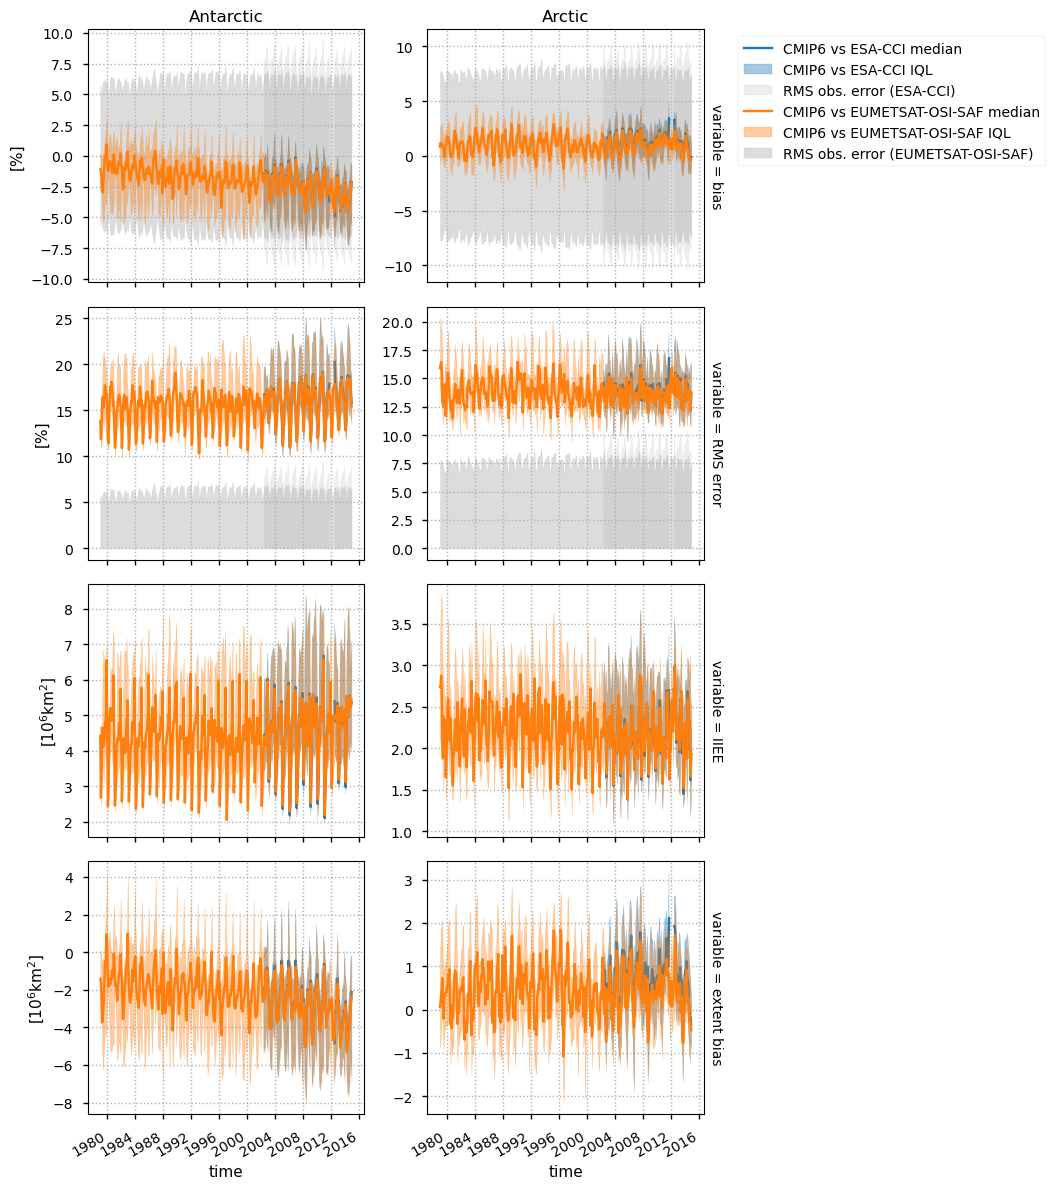

In [15]:
_ = plot_timeseries(ds_cmip6)

### Spatial distribution of errors
We compare 10-year averaged maps from 1985-2015m which is roughly the overlap period between the historical experiment and the EUMETSAT OSI-SAF product.

In [16]:
projections = {
    "Arctic" : ccrs.Stereographic(central_latitude=90.),
    "Antarctic" : ccrs.Stereographic(central_latitude=-90.),
}

# slices in x and y directions (on observation grid)
map_slices = {
    "Arctic": {'xc': slice(50, -100), 'yc': slice(50, -50)},
    "Antarctic": {'xc': slice(50, -50), 'yc': slice(50, -50)},
}

map_kwargs = {
    "datasets_eumetsat": datasets_eumetsat,
    "datasets_cmip6": datasets_cmip6,
    "projections": projections,
    "map_slices": map_slices,
}

#### Arctic minimum
Looking at the maps below for September, we can see there is a general underestimation in the pack ice and an overestimation in the MIZ and near the coasts. This pattern persists with time although the locations move as the Arctic ice cover shrinks with time. This may be a resolution effect, since roughly the same amount of ice (low bias in sea ice concentration) may just be being spread out over a larger area.

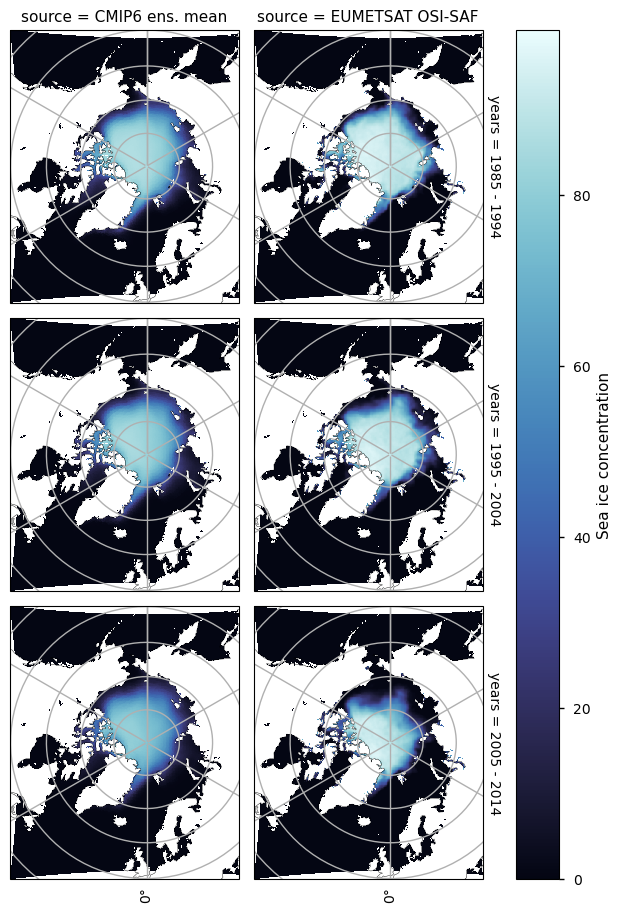

In [17]:
compare_sic_maps(region="Arctic", sel_dict={"month": "September"}, **map_kwargs)

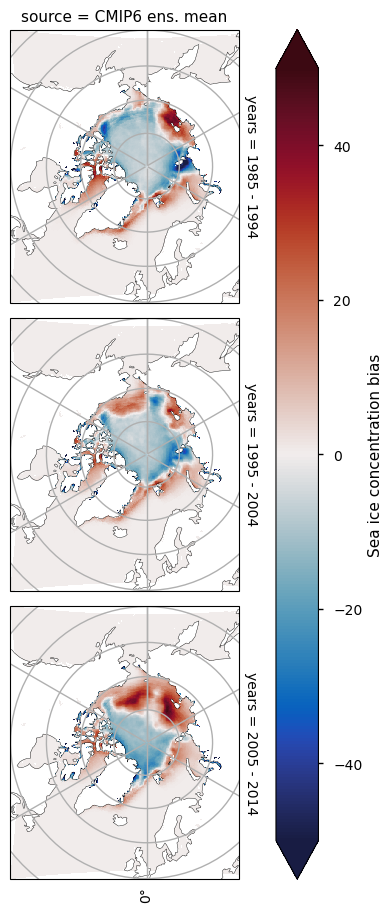

In [18]:
compare_sic_maps(region="Arctic", sel_dict={"month": "September"}, plot_func=make_sic_bias_maps, **map_kwargs)

#### Arctic maximum
Looking at the maps below for March, we can see the ice in the central Arctic is generally unbiased, but there are some areas where there is strong underestimation - the Bering Sea and the Sea of Okhotsk - and there is strong overestimation in the Greenland Sea and the North Atlantic Ocean near the entrance to Hudson Bay. Overall, the total ice area is roughly the same in CMIP6 and the satellite observations.

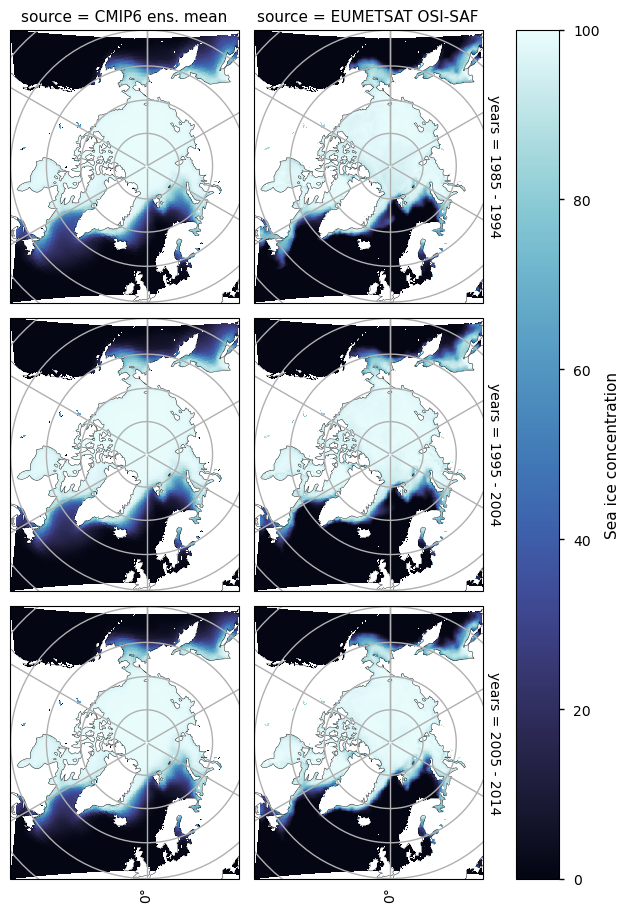

In [19]:
compare_sic_maps(region="Arctic", sel_dict={"month": "March"}, **map_kwargs)

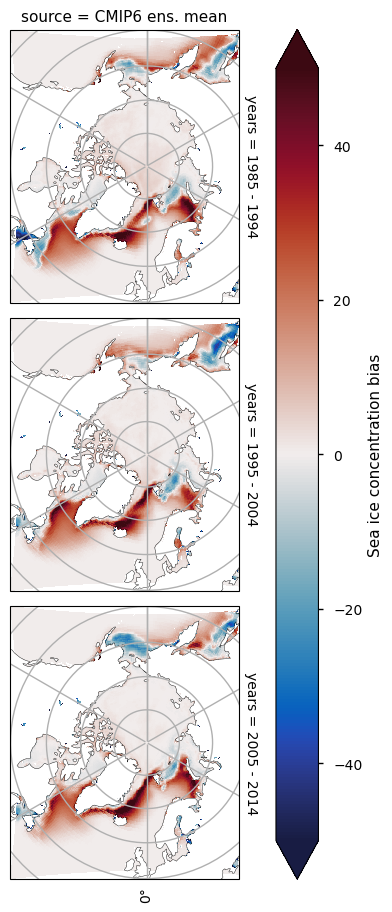

In [20]:
compare_sic_maps(region="Arctic", sel_dict={"month": "March"}, plot_func=make_sic_bias_maps, **map_kwargs)

#### Antarctic minimum
There is consistently too little ice on the Atlantic side of Antarctica (in the Weddell, Bellingshausen and Amundsen Seas). The amount of sea ice in those areas is also decreasing with time, while the concentration from satellite is staying relatively constant. On the Pacific and Indian ocean sides there is more of a dipole pattern (too little at the coast and too much away from it), probably due to the effect of low resolution in the CMIP6 models.

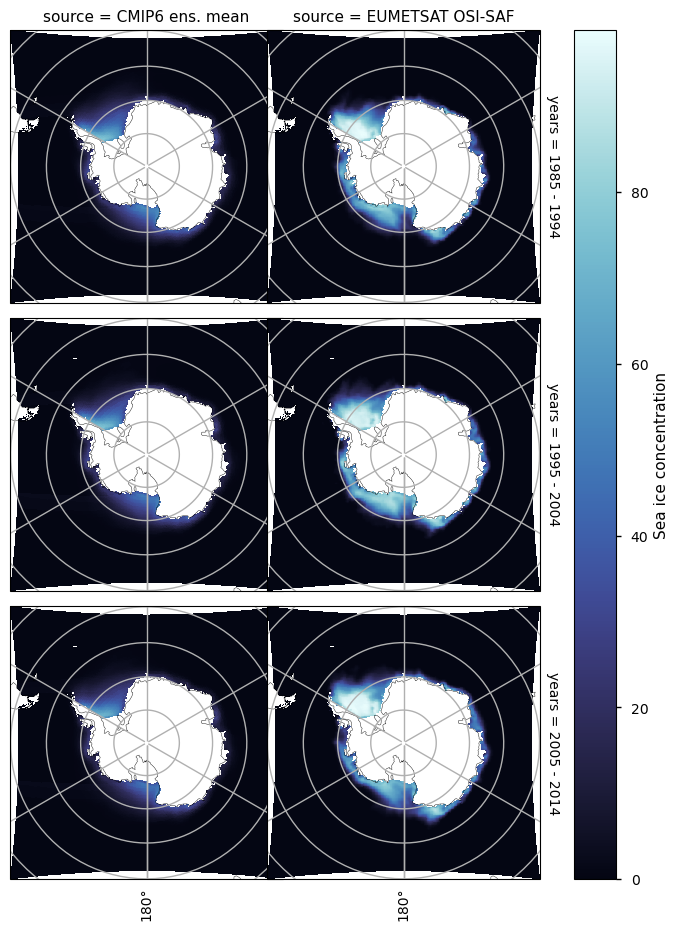

In [21]:
compare_sic_maps(region="Antarctic", sel_dict={"month": "March"}, **map_kwargs)

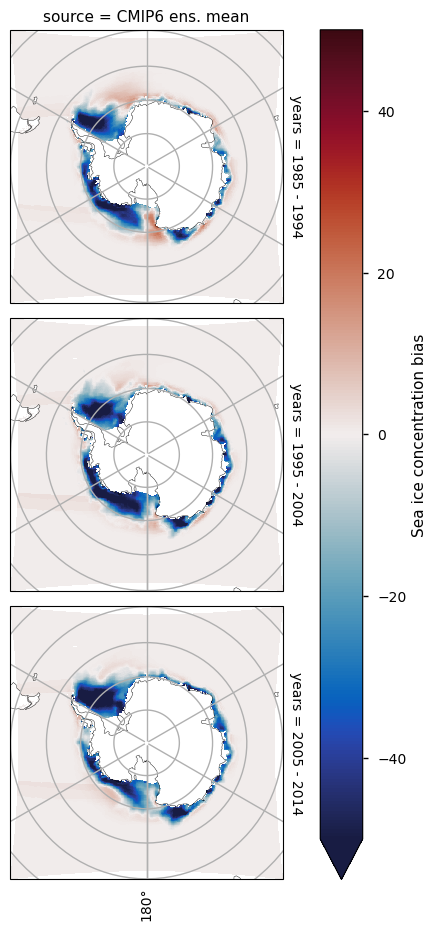

In [22]:
compare_sic_maps(region="Antarctic", sel_dict={"month": "March"},
                 plot_func=make_sic_bias_maps, **map_kwargs)

#### Antarctic maximum
For the month of September there is in general too little ice everywhere, although away from the coast at longitude about 140$^\circ$W in the Atlantic Ocean, and in the Indian Ocean the underestimation is most pronounced. The underestimation on those areas is also increasing with time, while the concentration from satellite is staying relatively constant in this month as well.

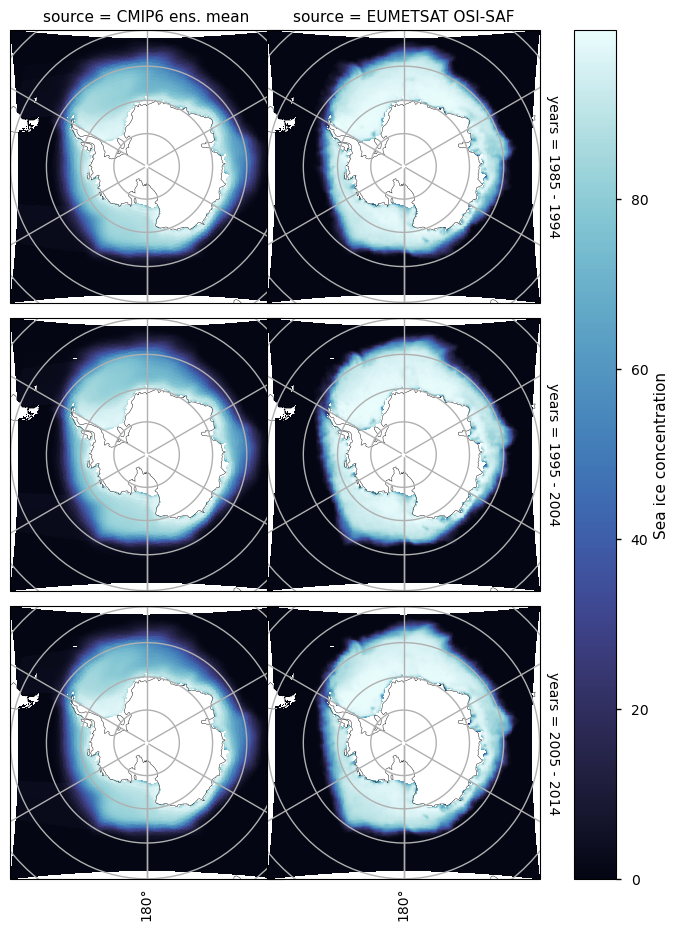

In [23]:
compare_sic_maps(region="Antarctic", sel_dict={"month": "September"}, **map_kwargs)

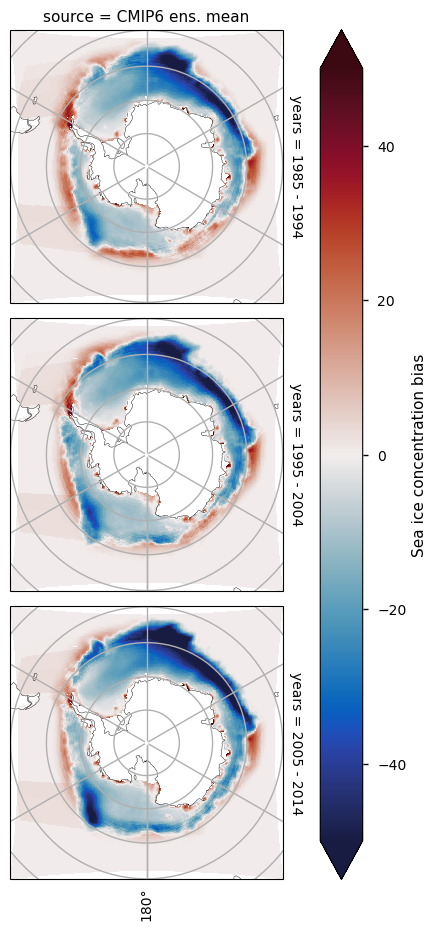

In [24]:
compare_sic_maps(region="Antarctic", sel_dict={"month": "September"},
                 plot_func=make_sic_bias_maps, **map_kwargs)

#### Arctic December
Since the month of December for the Arctic was quite interesting in the climate projections notebook from the point of view of the Arctic shipping routes, we also plot some maps for this month. The CMIP6 ensemble mean is quite close to the satellite data in the Arctic Ocean, with the main feature of the bias maps being the underestimation in the Hudson Bay.

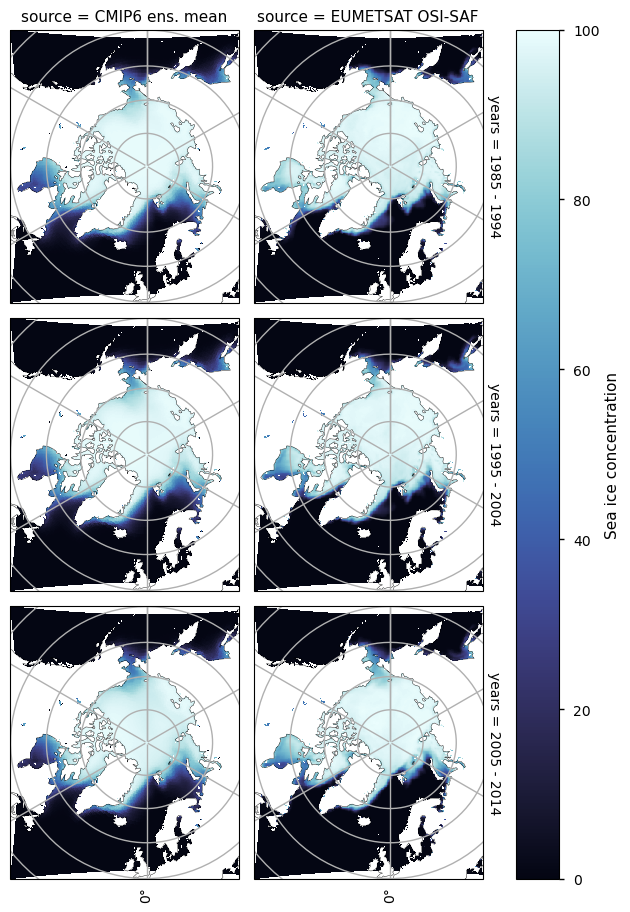

In [25]:
compare_sic_maps(region="Arctic", sel_dict={"month": "December"}, **map_kwargs)

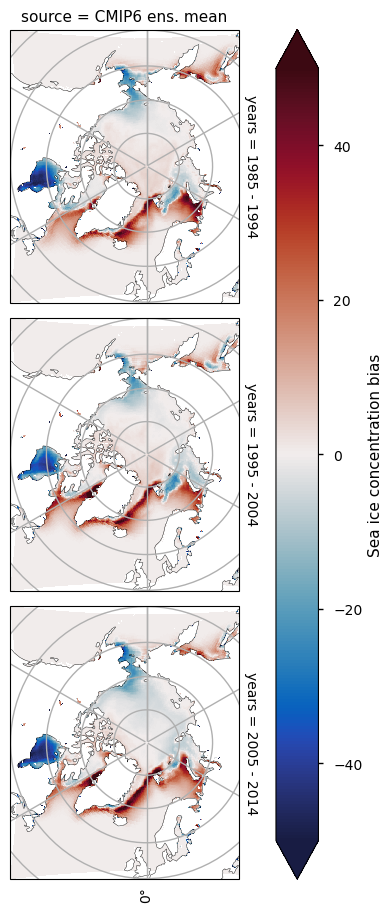

In [26]:
compare_sic_maps(region="Arctic", sel_dict={"month": "December"},
                 plot_func=make_sic_bias_maps, **map_kwargs)